# Sentiment Classification


## Loading the dataset

In [31]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import time

In [14]:
from keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

In [15]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

## Train test split

In [16]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

In [17]:
# checking the dataset shape
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (25000, 300)
y_train shape:  (25000,)
x_test shape:  (25000, 300)
y_test shape:  (25000,)


In [18]:
# checking first five review 
y_train[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [19]:
!mkdir model_checkpoints # folder for saving checkpoints
!mkdir models # folder for saving models for future use
!mkdir cnf # folder for saving models for future use

A subdirectory or file model_checkpoints already exists.
Error occurred while processing: model_checkpoints.
A subdirectory or file # already exists.
Error occurred while processing: #.
A subdirectory or file folder already exists.
Error occurred while processing: folder.
A subdirectory or file for already exists.
Error occurred while processing: for.
A subdirectory or file saving already exists.
Error occurred while processing: saving.
A subdirectory or file checkpoints already exists.
Error occurred while processing: checkpoints.
A subdirectory or file models already exists.
Error occurred while processing: models.
A subdirectory or file # already exists.
Error occurred while processing: #.
A subdirectory or file folder already exists.
Error occurred while processing: folder.
A subdirectory or file for already exists.
Error occurred while processing: for.
A subdirectory or file saving already exists.
Error occurred while processing: saving.
A subdirectory or file models already exist

In [20]:
# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# callback utility fxn for tensorboard, Initializing Early stopping and Model chekpoint callbacks**
# these fxn will be passed in model.fit 
def EarlyStopingModelCheckPoint():
    #tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 5 continous epochs

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training

    model_checkpoint =  ModelCheckpoint('model_checkpoints/checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               mode='auto',
                                                               period=1)
    return early_stopping, model_checkpoint

review = ['Positive', 'Negative']

def plot_cnf_matrix(cnf_matrix, name):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(review)
    ax.set_yticklabels(review)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('cnf/{}.png'.format(name), dpi=300)
    plt.show();
    
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        if(y_pred[i][0] > 0.50):
            result.append(1)
        else:
            result.append(0)
    return result

In [21]:
# define the model
model1 = Sequential()

# Embedding layer
model1.add(Embedding(vocab_size, 8, input_length=maxlen, name="embedding1"))

# Recurrent layer
model1.add(
    SimpleRNN(
        1, return_sequences=False, dropout=0.1, name="simple_rnn1"))

# Output layer: binary output
model1.add(Dense(1, activation='sigmoid', name="output"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
# compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
# summarize the model
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn1 (SimpleRNN)      (None, 1)                 10        
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 80,012
Trainable params: 80,012
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# fit the model
early_stopping,model_checkpoint = EarlyStopingModelCheckPoint()

history1 = model1.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64, # Number of observations per batch
                    verbose=1, # Print description after each epoch
                    callbacks=[early_stopping,model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 353s 14ms/step - loss: 0.5586 - acc: 0.7549 - val_loss: 0.6053 - val_acc: 0.6668

Epoch 00001: val_loss improved from inf to 0.60530, saving model to model_checkpoints/checkpoint_01_loss0.6053.h5
Epoch 2/50
25000/25000 [==============================] - 232s 9ms/step - loss: 0.4721 - acc: 0.8144 - val_loss: 0.4623 - val_acc: 0.8164

Epoch 00002: val_loss improved from 0.60530 to 0.46232, saving model to model_checkpoints/checkpoint_02_loss0.4623.h5
Epoch 3/50
25000/25000 [==============================] - 216s 9ms/step - loss: 0.4360 - acc: 0.8291 - val_loss: 0.4532 - val_acc: 0.8128

Epoch 00003: val_loss improved from 0.46232 to 0.45319, saving model to model_checkpoints/checkpoint_03_loss0.4532.h5
Epoch 4/50
25000/25000 [==============================] - 252s 10ms/step - loss: 0.4142 - acc: 0.8365 - val_loss: 0.4526 - val_acc: 0.8064

Epoch 00004: val_loss improved from 0.4531

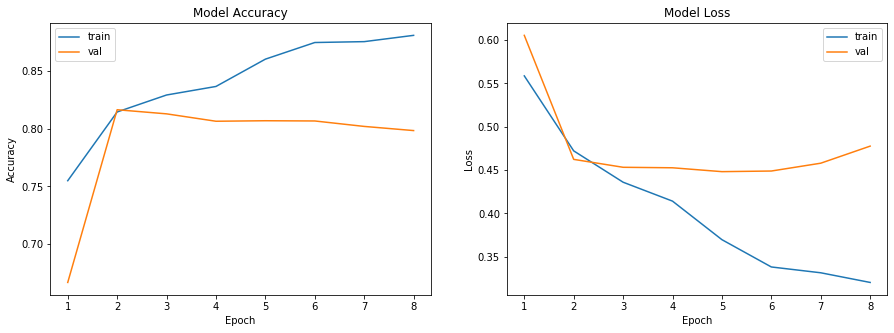

In [25]:
# plot model history
plot_model_history(history1)

In [26]:
# compute accuracy for validation dataset
val_loss1, val_acc1 = model1.evaluate(x_test, y_test, verbose=1)
print('\nExperiment1: Accuracy: %0.2f' %(val_acc1*100))

25000/25000 [==============================] - 166s 7ms/step

Experiment1: Accuracy: 79.83


In [27]:
# predict test data and get classification report
y_pred1 = model1.predict(x_test)
ypred1 = get1D_y_predict(y_pred1)

# classification report with model acciracy and F1 score
cr1 = metrics.classification_report(y_test,ypred1)
print("Classification Report: \n\n", cr1)

Classification Report: 

               precision    recall  f1-score   support

           0       0.77      0.86      0.81     12500
           1       0.84      0.74      0.78     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



In [28]:
# Save model and weights for future use. 
model1.save('models/exp1_model.h5')
model1.save_weights('exp1_weights.h5')

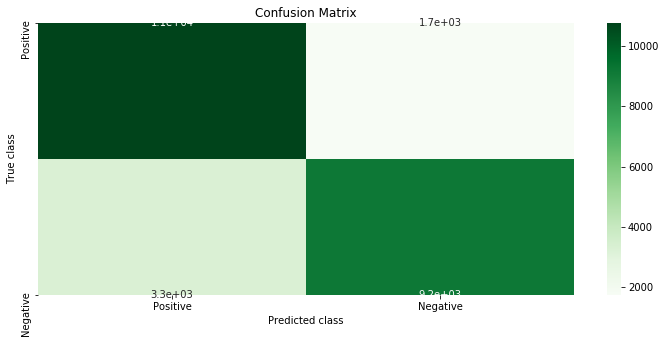

In [32]:
# confusion matrix
cm3 = metrics.confusion_matrix(y_test, ypred1)
plot_cnf_matrix(cm3, "exp3_cm")

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

In [33]:
from keras.models import load_model
model = load_model('models/exp1_model.h5')

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn1 (SimpleRNN)      (None, 1)                 10        
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 80,012
Trainable params: 80,012
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras import backend as K

inp = model.input                               # input placeholder
outputs = [layer.output for layer in model.layers ]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [36]:
# getting outpur at each layer for test sample

sample_pos = 100  # btw 0~24999
testSample = x_test[sample_pos][np.newaxis,...] # get the test sample

layer_outs = [func([testSample, 1.]) for func in functors] # get the output at each layer for the test sample

# print output at each layer
for idx, layer in enumerate(model.layers):
    print("\nLayer name: {}, Shape: {}: ".format(layer.name, layer_outs[idx][0][0].shape))
    print("Layer output")
    print(layer_outs[idx][0][0])


Layer name: embedding1, Shape: (300, 8): 
Layer output
[[ 0.00203719  0.03755599  0.00095761 ...  0.05155735  0.04745995
   0.01487463]
 [ 0.00203719  0.03755599  0.00095761 ...  0.05155735  0.04745995
   0.01487463]
 [ 0.00203719  0.03755599  0.00095761 ...  0.05155735  0.04745995
   0.01487463]
 ...
 [ 0.00120711 -0.0140387  -0.00928267 ... -0.00145953 -0.02471307
   0.04000523]
 [ 0.01005122 -0.04690026 -0.01622277 ...  0.0195183   0.06434371
   0.03296579]
 [-0.05817852 -0.06459054 -0.05457132 ...  0.00400955 -0.00482264
  -0.00979416]]

Layer name: simple_rnn1, Shape: (1,): 
Layer output
[0.5663294]

Layer name: output, Shape: (1,): 
Layer output
[0.10430717]


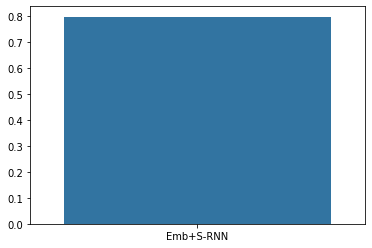

In [39]:
# comparing validation accuracy of all the experiments
models = ["Emb+S-RNN"]
model_acc = [val_acc1]
sns.barplot(x=models, y=model_acc)